# Overview
**From the Kaggle Description** 
**Data Set Information:**
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

**Attribute Information:**
Features consist of hourly average ambient variables

* Temperature (AT) in the range 1.81°C and 37.11°C
* Ambient Pressure (AP) in the range 992.89-1033.30 milibar
* Relative Humidity (RH) in the range 25.56% to 100.16%
* Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
* Net hourly electrical energy output (EP) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

# CCGT Notes
**It's important to know the basics of the cycle to better understand the data and where the variables come from. It can also lead to new features**
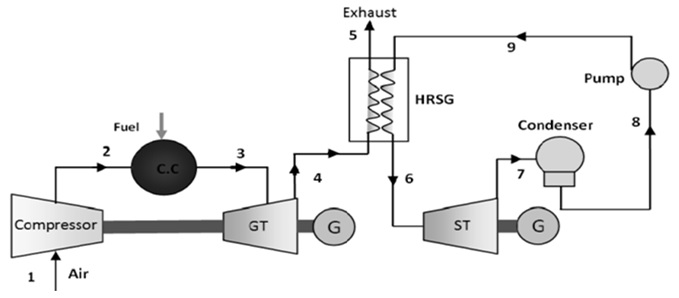

It's not safe to assume that the sensors are in close proximitity to the plant components (compressor, HRSG). However, the recorded values can still give an idea of the actual values of the state points in the cycle.
* Ambient Temperature (AT) and Ambient Pressure (AP) are related to the air quality entering **state 1** in the compressor.
* Exhaust Vacuum (V) pertains to the exhaust leaving **state 5** 
* Relative Humidity (RH) means the percentage amount of water vapor in the air to the amount of vapor that the air can hold in the given temperature (which is AT).
    * We can check later if the RH has some correlation with AT


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

%matplotlib inline 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration

In [ ]:
df = pd.read_csv('/kaggle/input/airpressure/Folds5x2_pp.csv')
df.head()

In [ ]:
df.tail()

In [ ]:
df.dtypes

In [ ]:
df.describe()

In [ ]:
#checking for null values
df.isnull().sum()/df.shape[0]

In [ ]:
df.PE.hist()
df.PE.hist(bins = 50)

In [ ]:

df[['AT', 'V', 'AP', 'RH']].hist()

* Temperature & exhaust vacuum show a somewhat bimodal distribution
* Abs Pressure has a normal distribution, while RH has a left skew

In [ ]:
plt.figure(figsize=(15,6))
sns.set(style="darkgrid")
sns.regplot(x = df.index, y = df.PE, x_bins=72)
sns.regplot(x = df.index, y = df.PE, x_bins=6)

****Assumption for the regplot: data points are evenly distributed between (2006-2011)****
* Regression plot to see any trends monthly or yearly
* no description in data of dates so placement of data points within the 6 yrs is uncertain
* just out of curiousity, applying Augmented Dicky-Fuller test to determine stationarity following assumption

In [ ]:
from statsmodels.tsa.stattools import adfuller

y_val = df.PE.values
result = adfuller(y_val)
result
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

0 p-value, ADF stat lower than 1% crit val = we can safely reject the null-hypothesis that the PE is time dependent.

In [ ]:
corr = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot = True)
plt.show()

AP and RH positively correlate to PE, while AT and V strongly negatively correlate to PE

In [ ]:
#copied from @VenkataramananKrishnan's nbk
plt.figure(figsize=(12,6))

sns.pairplot(df, diag_kind='hist')

plt.tight_layout()
plt.show()

**Other properties of air entering compressor can be retrieved since its Pressure and Temperature are given**

In [ ]:
!pip install --upgrade pip
!pip install pyromat
import pyromat as pm

In [ ]:
air = pm.get('ig.air')
enthalpy = air.h(T=8.34+273.15, p=1010.84/1000).item()


In [ ]:
#enthalpy is negative because enthalpy of formation(hf) is 0, mentioned in pyromat documentation
df['H']=df.apply(lambda x: air.h(T=x['AT']+273.15, p= x['AP']/1000).item(), axis =1)

#entropy
df['S']=df.apply(lambda x: air.s(T=x['AT']+273.15, p= x['AP']/1000).item(), axis =1)

#density
df['D']=df.apply(lambda x: air.d(T=x['AT']+273.15, p= x['AP']/1000).item(), axis =1)

#gam = heat capacity ratio
df['GAM']=df.apply(lambda x: air.gam(T=x['AT']+273.15, p= x['AP']/1000).item(), axis =1)

In [ ]:
plt.figure(figsize=(12,6))

sns.pairplot(df, diag_kind='hist')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#check for multicollinearity within all variables
X = df.drop('PE', axis=1)
X['constant']=1
X_vif = X[['V','AP','RH','AT', 'H','S','GAM','D','constant']]

pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])], index=X_vif.columns)

In [ ]:
#after some trial and error, all the new variables & AT were removed for future model building
X = df.drop('PE', axis=1)
X['constant']=1
X_vif = X[['V','AP','RH','constant']]

pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])], index=X_vif.columns)

# Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Scalers should be used for deep learning stuff, linear n logistic regression
not needed for xgboost, decision trees, random forests

In [ ]:
all_feature_cols=['V','AP','RH','AT', 'H','S','GAM','D']
feature_cols1=['V','AP', 'RH']

In [ ]:
norm = MinMaxScaler()
X_norm = df[all_feature_cols].copy()
X_norm[all_feature_cols] = norm.fit_transform(X_norm[all_feature_cols])

# Model Building

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

**Multilinear Regression**

In [ ]:
#Multiple Linear Regression
#MinMax
X_norm = X_norm[feature_cols1]
y_norm = df.PE

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size = 0.3, random_state=0)
reg_model1 = sm.OLS(y_train, X_train).fit()
reg_model1.summary()

In [ ]:
y_pred=reg_model1.predict(X_test)
print(f"rmse: {np.sqrt(mean_squared_error(y_pred, y_test))}")

**XGBoost**

In [ ]:
 xgb_params = {
     'n_estimators':800,
     'learning_rate': 0.07
 }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size = 0.3, random_state=0)
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train,
              eval_metric='rmse',
              early_stopping_rounds=10,
              eval_set=[(X_test, y_test)],
             verbose=50)

**Cross Validation**

In [ ]:
from sklearn.model_selection import KFold
kf =KFold(n_splits=10)

In [ ]:
ols_rsme1 = []
log_rsme1 = []
xgb_rsme1 = []

for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm.iloc[train_index, :], X_norm.iloc[test_index,:]
    y_train, y_test = y_norm.iloc[train_index], y_norm.iloc[test_index]
    
    reg_model = sm.OLS(y_train, X_train).fit()
    y_pred=reg_model.predict(X_test)
    ols_rsme1.append(np.sqrt(mean_squared_error(y_pred, y_test)))

    xgb_model.fit(X_train, y_train,
              eval_metric='rmse',
              early_stopping_rounds=10,
              eval_set=[(X_test, y_test)],
             verbose=False)
    y_pred=xgb_model.predict(X_test)
    xgb_rsme1.append(np.sqrt(mean_squared_error(y_pred, y_test)))

In [ ]:
print(f"ols rsme: {np.mean(ols_rsme1)}")
print(f"xgb rsme: {np.mean(xgb_rsme1)}")

# End Notes
* Not enough variables and background information about data to determine PE through engineering computations
* Given variables showed multicollinearity (V & AT) which can be attributed to thermodynamic principles
* Other features based from thermodynamics (from RH and V) can be explored besides the properties of air in state 1(H, S, D, GAM)